# EDA, Text, Processing, and Feature Engineering

In [1]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

### Load in DataFrame

In [2]:
df = pd.read_csv('data/poetry_foundation_raw_rescrape.csv', index_col=0)
df.head()

,poet_url,genre,poem_url,poet,title,poem_lines,poem_string
0,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48578/at-the-california-institute-of-technology,Richard Brautigan,At the California Institute of Technology,"['I don’t care how God-damn smart', '\r these guys are: I’m bored.', '', '\r It’s been raining like hell all day long', '\r and there’s nothing to...",I don’t care how God-damn smart\n\r these guys are: I’m bored.\n\n\r It’s been raining like hell all day long\n\r and there’s nothing to do.\n
1,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48576/a-boat,Richard Brautigan,A Boat,"['O beautiful ', 'was the werewolf ', 'in his evil forest. ', 'We took him ', 'to the carnival ', 'and he started ', ' crying ', 'when h...",O beautiful \nwas the werewolf \nin his evil forest. \nWe took him \nto the carnival \nand he started \n crying \nwhen he saw \nthe Ferr...
2,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48580/december-30,Richard Brautigan,December 30,"['At 1:03 in the morning a fart', '\r smells like a marriage between', '\r an avocado and a fish head.', '', '\r I have to get out of bed', '\r to...",At 1:03 in the morning a fart\n\r smells like a marriage between\n\r an avocado and a fish head.\n\n\r I have to get out of bed\n\r to write this ...
3,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48579/the-double-bed-dream-gallows,Richard Brautigan,The Double-Bed Dream Gallows,"['Driving through ', '\r hot brushy country', '\r in the late autumn, ', '\r I saw a hawk', '\r crucified on a', '\r barbed-wire fence.', '', ...","Driving through \n\r hot brushy country\n\r in the late autumn, \n\r I saw a hawk\n\r crucified on a\n\r barbed-wire fence.\n\n\r I guess as a..."
4,https://www.poetryfoundation.org/poets/richard-brautigan,beat,https://www.poetryfoundation.org/poems/48581/haiku-ambulance,Richard Brautigan,Haiku Ambulance,"['A piece of green pepper', '\r fell', '\r off the wooden salad bowl:', '\r so what?', '']",A piece of green pepper\n\r fell\n\r off the wooden salad bowl:\n\r so what?\n


In [3]:
df.shape

(4626, 7)

#### Saving to CSV converts the poem_lines lists into a string, so we'll use our destringify function to convert it back to a list format.

In [4]:
df.loc[2,'poem_lines']

"['At 1:03 in the morning a fart', '\\r smells like a marriage between', '\\r an avocado and a fish head.', '', '\\r I have to get out of bed', '\\r to write this down without', '\\r    my glasses on.', '']"

In [5]:
df['poem_lines'] = df['poem_lines'].apply(destringify)
df.loc[2,'poem_lines']

['At 1:03 in the morning a fart',
 '\r smells like a marriage between',
 '\r an avocado and a fish head.',
 '',
 '\r I have to get out of bed',
 '\r to write this down without',
 '\r    my glasses on.',
 '']

#### Let's look at our class imbalance.

In [6]:
# number of poems per genre
df.genre.value_counts()

modern                            1279
victorian                          643
romantic                           398
imagist                            356
new_york_school                    264
black_mountain                     257
new_york_school_2nd_generation     192
language_poetry                    192
confessional                       176
black_arts_movement                165
georgian                           160
objectivist                        159
harlem_renaissance                 148
beat                               147
fugitive                            90
Name: genre, dtype: int64

In [7]:
# percentage of total poems by genre
df.genre.value_counts(normalize=True)

modern                            0.276481
victorian                         0.138997
romantic                          0.086035
imagist                           0.076956
new_york_school                   0.057069
black_mountain                    0.055556
new_york_school_2nd_generation    0.041505
language_poetry                   0.041505
confessional                      0.038046
black_arts_movement               0.035668
georgian                          0.034587
objectivist                       0.034371
harlem_renaissance                0.031993
beat                              0.031777
fugitive                          0.019455
Name: genre, dtype: float64

In [8]:
# cumulative percentage of total poems by genre
df.genre.value_counts(normalize=True).cumsum()

modern                            0.276481
victorian                         0.415478
romantic                          0.501513
imagist                           0.578470
new_york_school                   0.635538
black_mountain                    0.691094
new_york_school_2nd_generation    0.732598
language_poetry                   0.774103
confessional                      0.812149
black_arts_movement               0.847817
georgian                          0.882404
objectivist                       0.916775
harlem_renaissance                0.948768
beat                              0.980545
fugitive                          1.000000
Name: genre, dtype: float64

In [9]:
# number of unique poets per genre
{genre:len(poets) for genre,poets in df.groupby('genre').poet.unique().items()}

{'beat': 13,
 'black_arts_movement': 18,
 'black_mountain': 10,
 'confessional': 9,
 'fugitive': 7,
 'georgian': 18,
 'harlem_renaissance': 14,
 'imagist': 7,
 'language_poetry': 14,
 'modern': 54,
 'new_york_school': 11,
 'new_york_school_2nd_generation': 16,
 'objectivist': 6,
 'romantic': 50,
 'victorian': 56}

## Initial feature creation
#### Number of lines column -- first clean up the lines, then count them

In [10]:
df.loc[2,'poem_lines']

['At 1:03 in the morning a fart',
 '\r smells like a marriage between',
 '\r an avocado and a fish head.',
 '',
 '\r I have to get out of bed',
 '\r to write this down without',
 '\r    my glasses on.',
 '']

In [11]:
df['clean_lines'] = df.poem_lines.apply(line_cleaner)

In [12]:
df.loc[2,'clean_lines']

['At 1:03 in the morning a fart',
 'smells like a marriage between',
 'an avocado and a fish head.',
 'I have to get out of bed',
 'to write this down without',
 'my glasses on.']

In [13]:
df['num_lines'] = df.clean_lines.apply(lambda x: len(x))

In [14]:
df.loc[0,'num_lines']

4

#### Use function to obtain average line length

In [15]:
line_averager(df.loc[0,'clean_lines'])

6.0

In [16]:
df['avg_len_line'] = df.clean_lines.apply(line_averager)

#### Let's look at our new continuous variables, as a whole and by genre

In [17]:
# number of lines and average length of line as a whole
df.describe()

,num_lines,avg_len_line
count,4626.000000,4626.000000
mean,35.307393,6.740853
std,57.993187,13.279562
min,1.000000,1.000000
25%,14.000000,4.981928
50%,22.000000,6.181818
75%,32.000000,7.403959
max,892.000000,808.000000


In [18]:
# number of lines by genre
df.groupby('genre').num_lines.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,42.149660,41.872727,29.536965,39.625000,27.155556,23.918750,24.195946,23.573034,35.666667,24.039875,31.753788,37.598958,38.742138,55.381910,56.017107
std,53.278842,33.404426,30.634048,57.829268,36.628997,18.370736,31.787487,28.003878,45.773667,34.294989,31.777685,45.920037,52.727411,100.307863,95.064225
min,4.000000,1.000000,3.000000,4.000000,5.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,5.000000,4.000000,4.000000
25%,18.000000,21.000000,16.000000,18.000000,14.000000,13.750000,12.000000,12.000000,18.000000,13.000000,19.000000,15.000000,15.500000,14.000000,15.000000
50%,25.000000,31.000000,23.000000,24.500000,21.000000,19.500000,16.000000,19.000000,24.000000,18.000000,25.000000,23.000000,23.000000,24.000000,24.000000
75%,40.000000,54.000000,29.000000,36.500000,27.000000,26.000000,24.250000,25.000000,36.000000,25.000000,32.250000,35.000000,31.500000,48.750000,53.000000
max,331.000000,157.000000,256.000000,515.000000,323.000000,143.000000,249.000000,256.000000,476.000000,605.000000,383.000000,289.000000,410.000000,810.000000,892.000000


In [19]:
# average length of line by genre
df.groupby('genre').avg_len_line.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,6.772666,6.702930,5.083678,6.510876,7.325695,6.674091,6.221792,5.968957,6.964149,6.548417,7.622668,10.977673,4.653417,6.820372,7.106097
std,4.482858,6.939338,6.163613,1.452844,1.199446,1.432713,3.554699,6.991383,17.954290,5.939374,4.209417,58.557188,1.743705,1.216797,1.857445
min,1.307692,2.840000,1.571429,2.888889,4.035714,3.500000,1.801136,1.421053,1.000000,1.333333,2.523810,1.000000,1.578947,3.600000,3.375000
25%,4.749020,4.710145,3.611111,5.538462,6.628750,5.661184,4.524737,4.000000,3.191667,5.115556,5.920168,4.390282,3.407792,5.932735,5.958896
50%,5.666667,5.785714,4.571429,6.352199,7.407407,6.531250,5.693750,5.154762,4.393382,6.145729,7.139610,6.233718,4.349206,6.822917,6.798077
75%,7.164836,7.275862,5.633333,7.392816,8.008984,7.752500,7.342193,6.242500,7.326577,7.235294,8.129902,7.929762,5.809524,7.639860,8.000000
max,32.181818,88.000000,100.500000,16.340708,11.250000,13.500000,33.800000,105.666667,235.000000,139.000000,42.500000,808.000000,8.920000,11.791667,22.500000


### Let's look at some boxplots of this information

### Number of lines -- Boxplot

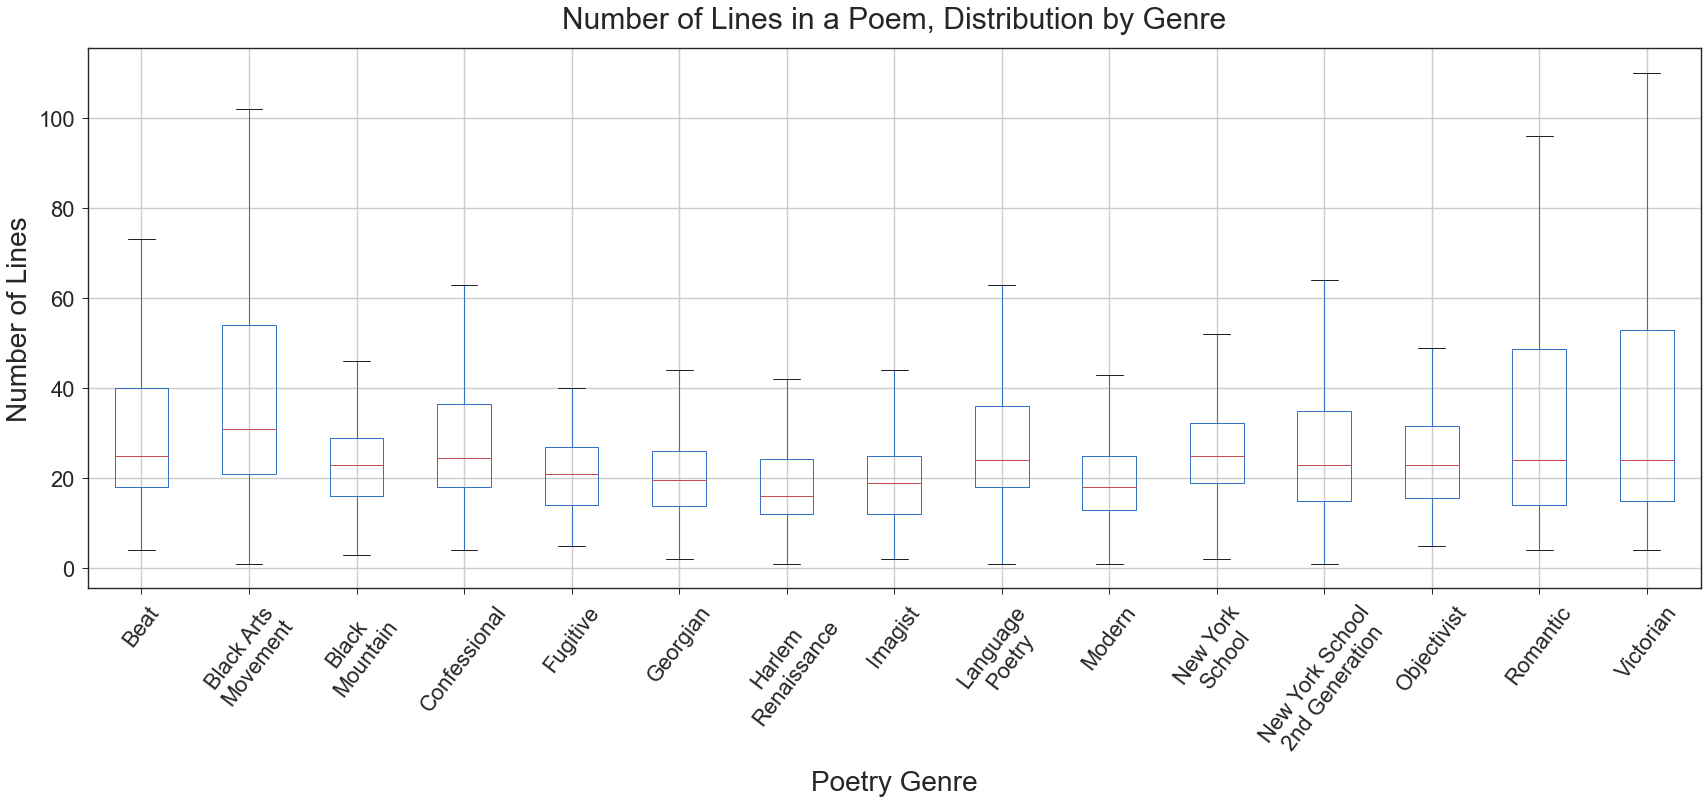

In [20]:
sns.set_style('ticks')

df.boxplot('num_lines', 'genre', showfliers=False, figsize=(28,10))
plt.title('Number of Lines in a Poem, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Number of Lines', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Some promise here, though the medians look fairly similar

### Average Line Length -- Boxplot

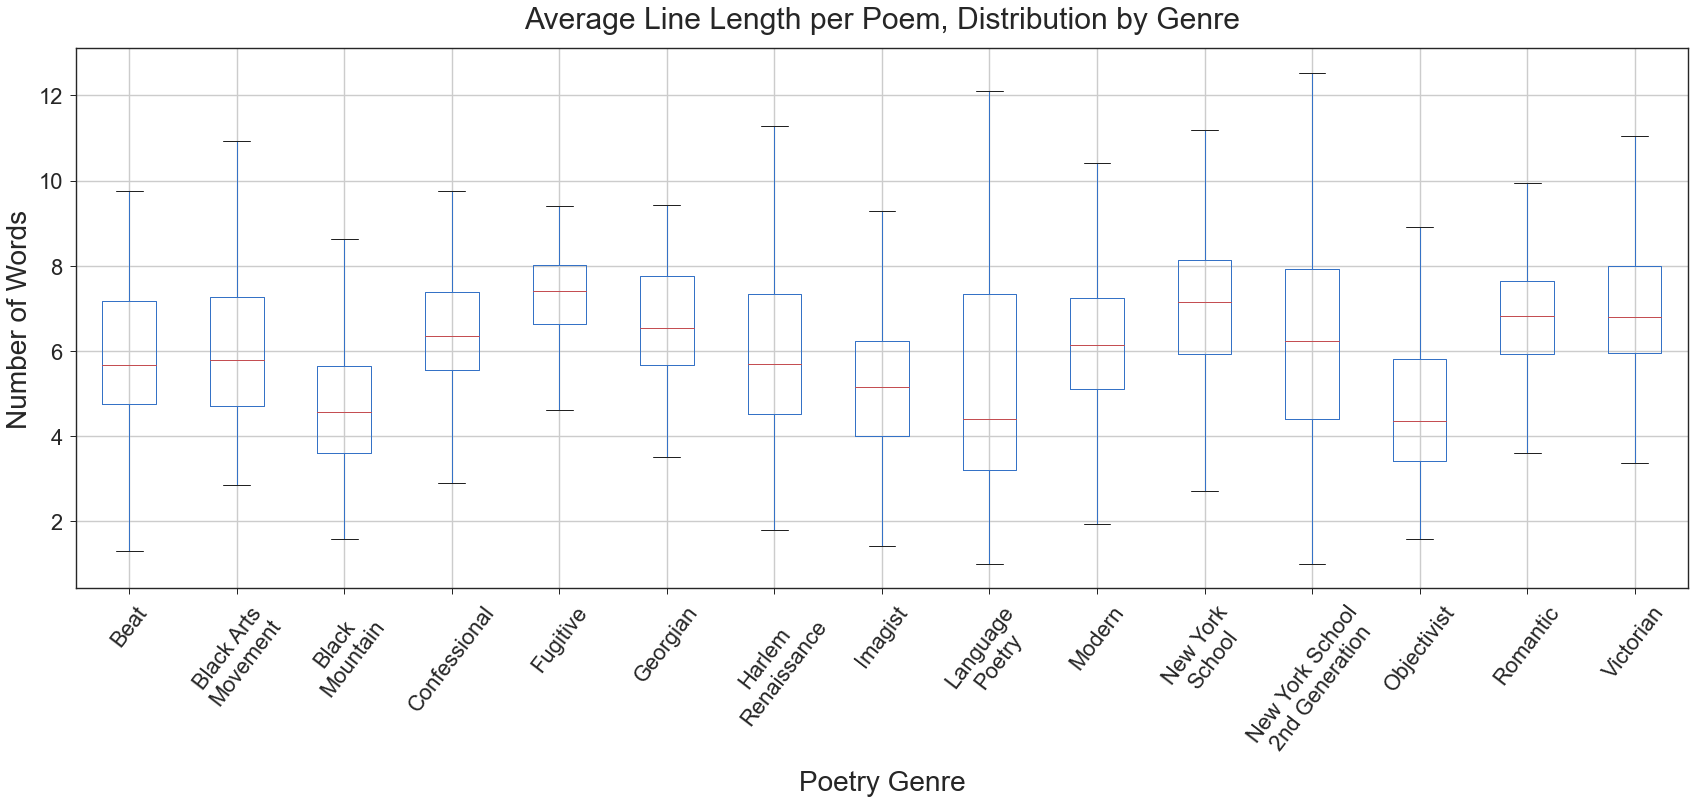

In [21]:
df.boxplot('avg_len_line', 'genre', showfliers=False, figsize=(28,10))
plt.title('Average Line Length per Poem, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Number of Words', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Definitely some promise here -- average line length appears to be very telling
### A look at polarity by genre

In [22]:
# instantiate VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score, passing in the raw poem
df['sentiment_polarity_score'] = df['poem_string'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [23]:
# may be handy to also have this as a categorical variable
conditions = [
    df.sentiment_polarity_score >= .05,
    df.sentiment_polarity_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment_polarity'] = np.select(conditions, choices, 'neutral')

In [24]:
# polarity score by genre
df.groupby('genre').sentiment_polarity_score.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,0.211505,0.019956,0.298936,0.082119,0.121377,0.038297,0.143196,0.269458,0.157053,0.211510,0.442634,0.367180,0.152358,0.511530,0.363730
std,0.751574,0.822611,0.640693,0.794445,0.753841,0.789306,0.750819,0.658530,0.654778,0.707653,0.661167,0.681735,0.694334,0.717514,0.785391
min,-0.999800,-0.999400,-0.998200,-0.997000,-0.996200,-0.998000,-0.998700,-0.997900,-0.996500,-0.998100,-0.985900,-0.998600,-0.992100,-0.999700,-0.999900
25%,-0.613250,-0.896800,-0.140600,-0.802525,-0.657175,-0.834350,-0.614775,-0.296000,-0.476700,-0.508550,-0.129600,-0.042200,-0.530850,0.254200,-0.517650
50%,0.434400,0.177900,0.510600,0.326200,0.318700,0.000000,0.327550,0.496100,0.279800,0.461200,0.797000,0.670500,0.273200,0.938800,0.868900
75%,0.925700,0.859100,0.864600,0.895650,0.888500,0.921150,0.880425,0.865650,0.789800,0.880950,0.952300,0.940300,0.818850,0.987700,0.980650
max,0.997600,0.998200,0.996300,0.999900,0.999600,0.998100,0.995900,0.997900,0.996100,0.999900,0.999700,0.999500,0.998100,1.000000,1.000000


### Polarity score -- Boxplot

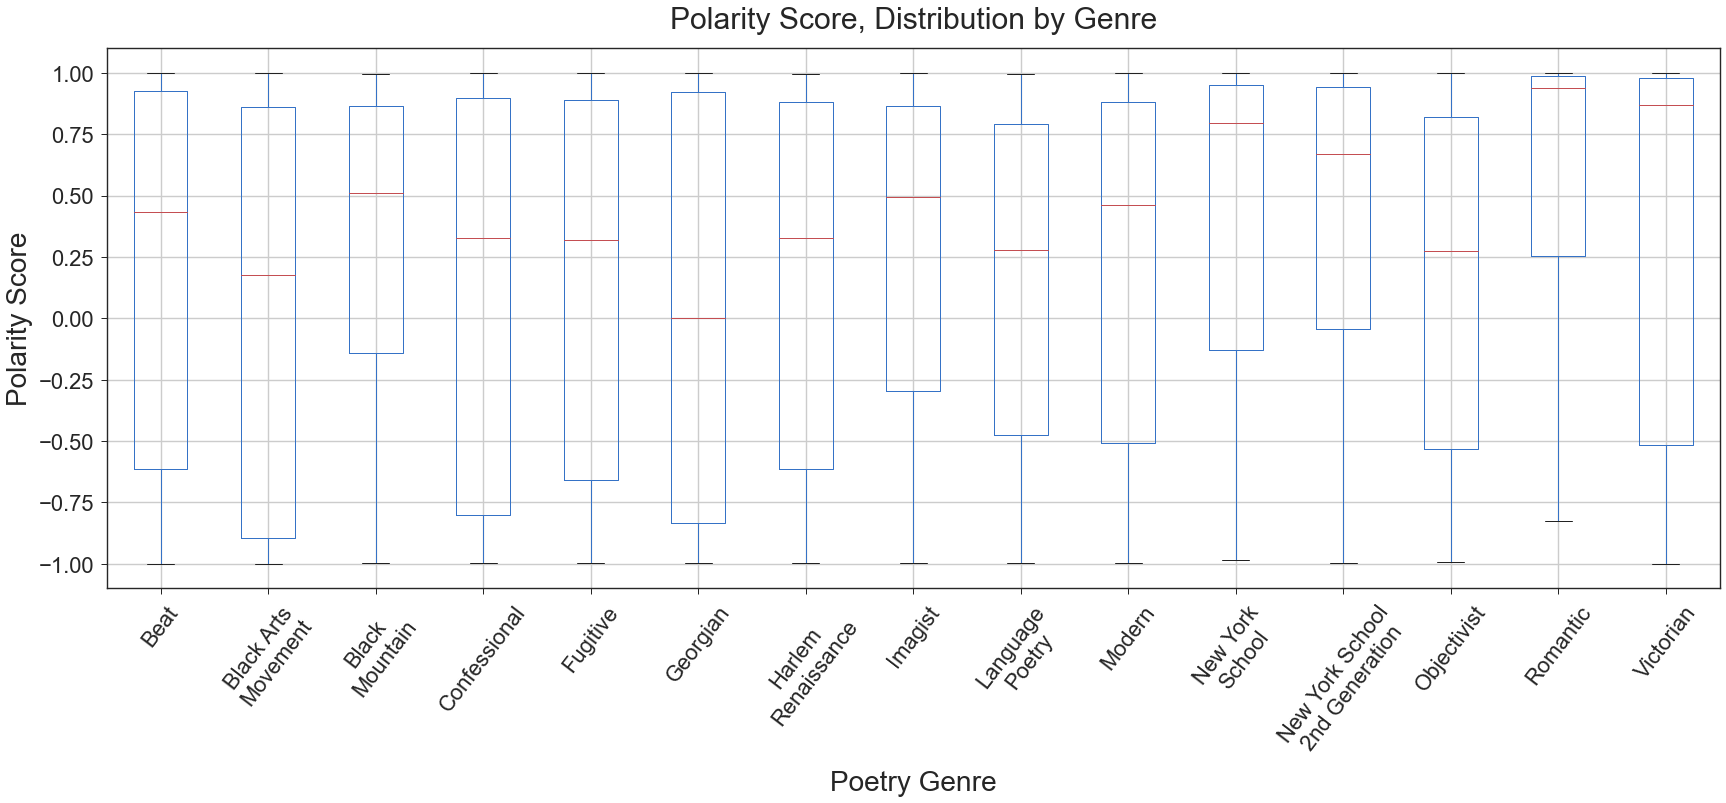

In [25]:
df.boxplot('sentiment_polarity_score', 'genre', showfliers=False, figsize=(28,10))
plt.title('Polarity Score, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Polarity Score', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Some definitely telling differences in polarity here

### Polarity -- Stacked bar chart

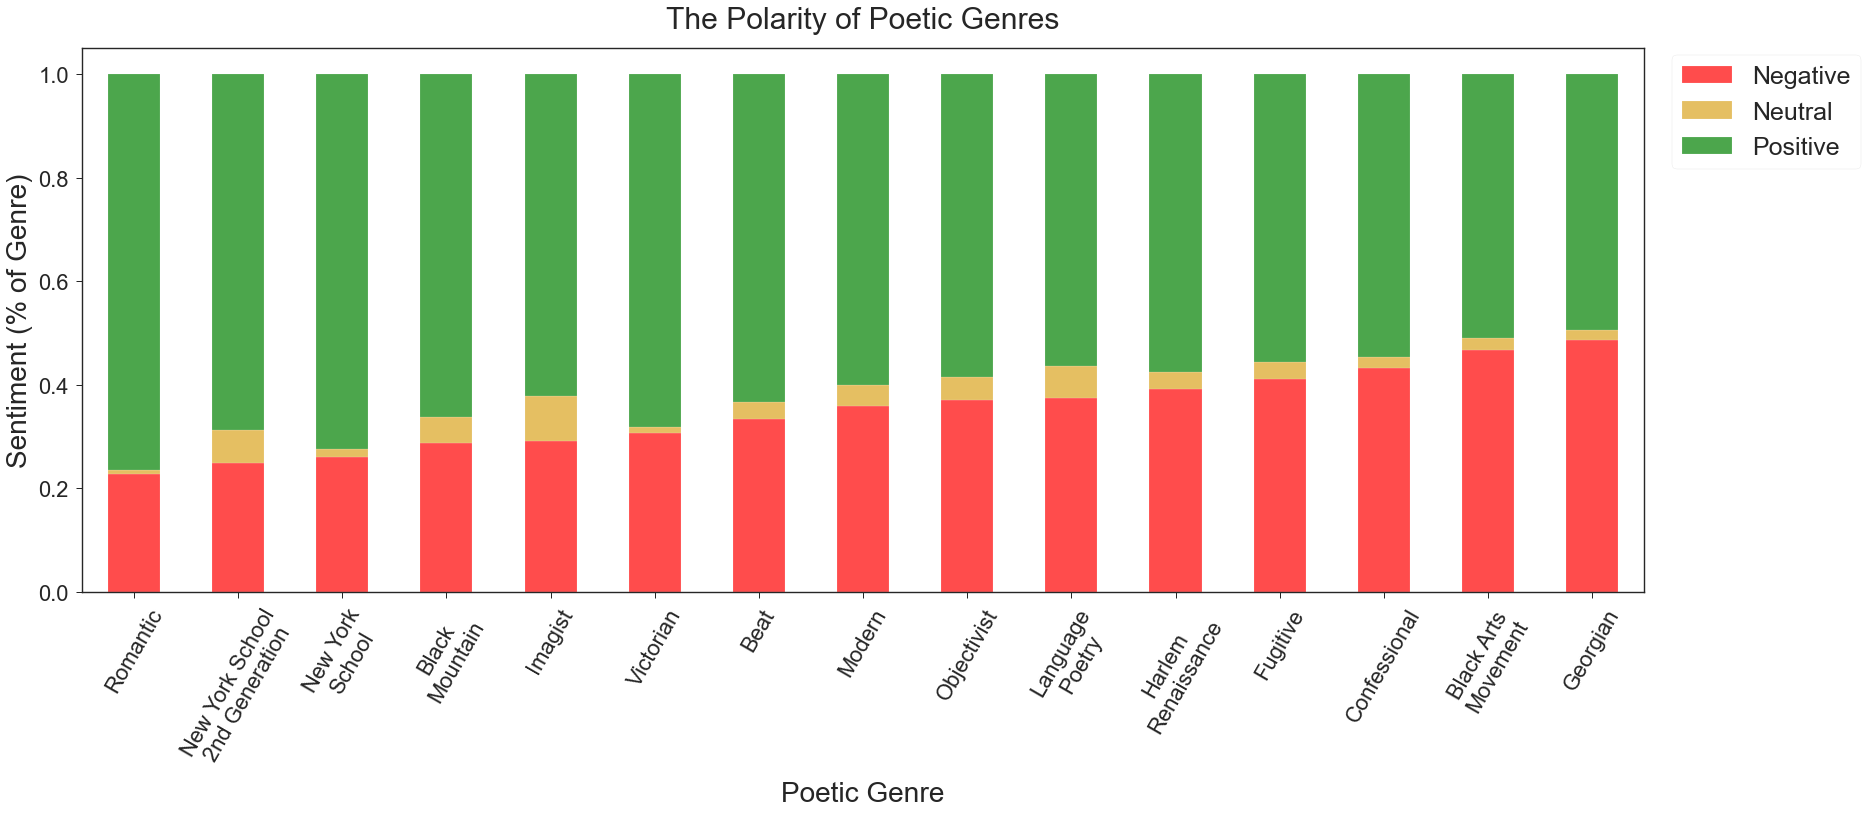

In [26]:
# Proportion of polarity across genre
genre_polarity_dist = df.groupby('genre').sentiment_polarity.value_counts(normalize=True).unstack().sort_values('negative')

genre_polarity_dist.plot(kind='bar', stacked = True, figsize=(28,10), 
                               color = ['red', 'goldenrod', 'green'], alpha = .70, fontsize=14)


plt.title('The Polarity of Poetic Genres', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetic Genre', fontsize=28, labelpad=10)
plt.ylabel('Sentiment (% of Genre)', fontsize=28, labelpad=5)

# obtain x-tick-labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[-2] = 'Black Arts\nMovement'
labels_pretty[2] = 'New York\nSchool'
labels_pretty[1] = 'New York School\n2nd Generation'

plt.xticks(ticks=locs, labels=labels_pretty, rotation=60, fontsize=22)

plt.yticks(fontsize=22);

plt.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1, bbox_to_anchor=(1.01, 1.01),
          fontsize=25);

#### Polarity differences made even more clear here

### A look at subjectivity by genre

In [27]:
# create a column with the compound polarity score, passing in the raw poem
df['sentiment_subjectivity_score'] = df['poem_string'].apply(lambda x: tb(x).sentiment.subjectivity)

# a look at subjectivity score overall
df.sentiment_subjectivity_score.describe()

count    4626.000000
mean        0.476474
std         0.141628
min         0.000000
25%         0.405556
50%         0.484001
75%         0.552169
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

In [28]:
# subjectivity score by genre
df.groupby('genre').sentiment_subjectivity_score.describe().T

genre,beat,black_arts_movement,black_mountain,confessional,fugitive,georgian,harlem_renaissance,imagist,language_poetry,modern,new_york_school,new_york_school_2nd_generation,objectivist,romantic,victorian
count,147.000000,165.000000,257.000000,176.000000,90.000000,160.000000,148.000000,356.000000,192.000000,1279.000000,264.000000,192.000000,159.000000,398.000000,643.000000
mean,0.485920,0.486905,0.473442,0.449826,0.452348,0.493294,0.461606,0.464208,0.452016,0.472870,0.478922,0.443955,0.467951,0.516769,0.489887
std,0.135374,0.129872,0.134837,0.095791,0.113385,0.135854,0.167038,0.178107,0.159750,0.155394,0.109665,0.161278,0.160679,0.111608,0.106527
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.408879,0.405116,0.393194,0.396533,0.390881,0.421864,0.372917,0.378507,0.386667,0.393127,0.414705,0.396785,0.373066,0.462876,0.433333
50%,0.500000,0.495718,0.467163,0.455133,0.452803,0.493211,0.477050,0.466237,0.456692,0.483929,0.472457,0.465885,0.481250,0.517955,0.500000
75%,0.569556,0.548506,0.558163,0.516742,0.531264,0.568246,0.553571,0.567130,0.543769,0.558333,0.545418,0.526549,0.550000,0.569783,0.542774
max,1.000000,1.000000,1.000000,0.788889,0.683333,1.000000,0.888889,0.933333,1.000000,1.000000,1.000000,0.900000,1.000000,0.950000,0.944444


### Subjectivity score -- Boxplot

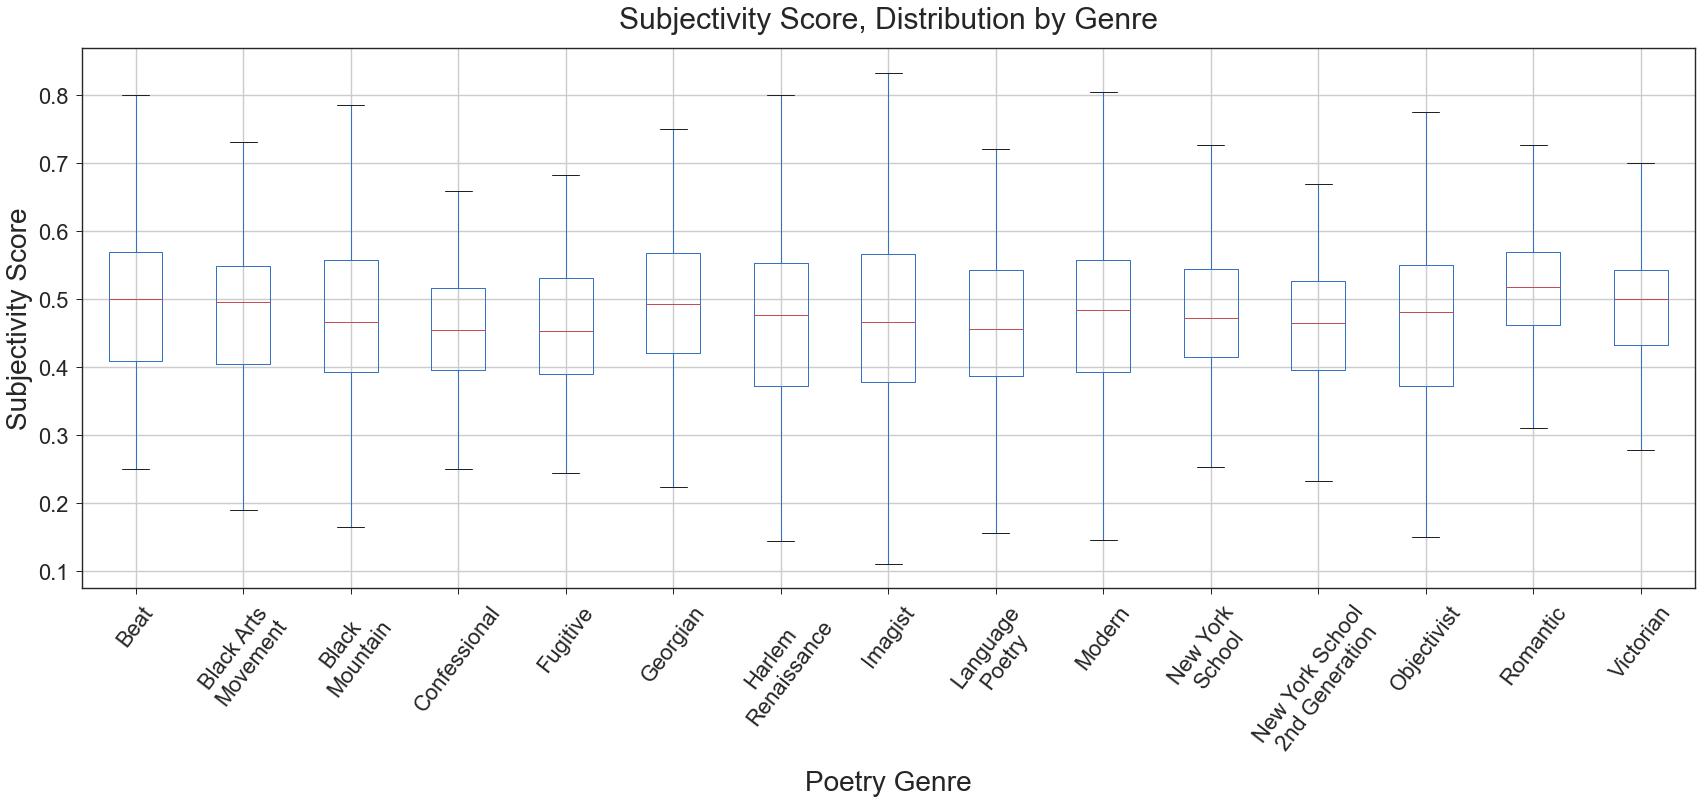

In [29]:
df.boxplot('sentiment_subjectivity_score', 'genre', showfliers=False, figsize=(28,10))
plt.title('Subjectivity Score, Distribution by Genre', fontsize=30, pad=20)
plt.suptitle('')
plt.xlabel('Poetry Genre', fontsize=28, labelpad=10)
plt.ylabel('Subjectivity Score', fontsize=28, labelpad=5)

# obtain x-tick labels and their locations
locs, labels = plt.xticks()
# prettify the labels
labels_pretty = [label.get_text().replace('_', '\n').title() for label in list(labels)]
labels_pretty[1] = 'Black Arts\nMovement'
labels_pretty[-5] = 'New York\nSchool'
labels_pretty[-4] = 'New York School\n2nd Generation'
# plot the labels
plt.xticks(ticks=locs, labels=labels_pretty, rotation=52.5, fontsize=22)

plt.yticks(fontsize=22);

#### Subjectivity seems fairly similar across all genres

## Text Processing
#### First, let's save our dataframe (I'll be pickling now to try to avoid having to destringify columns)

In [30]:
# # uncomment to save
# with gzip.open('data/poetry_genres_df.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_genres_df.pkl', 'rb') as hello:
#     df = pickle.load(hello)

In [31]:
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score'],
      dtype='object')

#### Then we can separate our target variable and creating a features dataframe 

In [ ]:
target = df['genre']
features = df[['title', 'clean_lines', 'num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_polarity',
               'sentiment_subjectivity_score']]

In [ ]:
# since I'll be treating the title as part of the poem, combine title and lines
# NOTE: a pesky float ValueError solved by casting str() on values, even though it seems like everything was a string already
features['lines_titled'] = features['title'].apply(lambda x: [str(x)]) + features['clean_lines']
features.loc[2,'lines_titled']

In [ ]:
features['string_titled'] = features.lines_titled.apply(lambda x: ' '.join(x))
features.loc[2,'string_titled']

#### Now we can drop the title and clean_lines columns

In [ ]:
features.drop(columns=['title', 'clean_lines'], inplace=True)
features.columns

In [ ]:
df[df.poem_string.str.contains('<')]

In [ ]:
# start with NLTK stop words
stop_words = stopwords.words('english')

In [ ]:
# Apply text cleaning techniques
def clean_text(text, stop_words):
    '''Make text lowercase, remove mentions, remove links, convert emoticons/emojis to words, remove punctuation
    (except apostrophes), tokenize words (including contractions), convert contractions to full words,
    remove stop words.'''
    
    # make text lowercase
    text = text.lower() 
    
    # remove mentions
    text = re.sub("(@[A-Za-z0-9]+)", "", text)
    
    # remove links
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'pic\.\S+', '', text)
    
    # convert emoticons
    emoticons = load_dict_emoticons()
    words = text.split()
    words_edit = [emoticons[word] if word in emoticons else word for word in words]
    tweet = ' '.join(words_edit)

    # convert emojis
    text = emoji.demojize(text)
    text = text.replace(':', ' ') # separate emojis-words with space
    
    # remove punctuation
    text = text.replace('...', ' ') # special cases
    text = text.replace('-', ' ')
    text = text.translate(str.maketrans('', '', '!"$%&*()+,./;<=>?@[\\]^_`{|}~')) 
    
    # tokenize words
    tokenizer = RegexpTokenizer("(#?[a-zA-Z]+[0-9]*(?:'[a-zx]+)?)")
    words = tokenizer.tokenize(text)
    
    # convert contractions
    contractions = load_dict_contractions()
    words = text.split()
    words_edit = [contractions[word] if word in contractions else word for word in words]
    text = ' '.join(words_edit)

    # remove stop words and lemmatize
    lemmatizer = WordNetLemmatizer()
    words = tokenizer.tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

### First go at vectorizing -- TF-IDF Vectorizer